# La Palma Earthquakes

Steve Purves [](https://orcid.org/0000-0002-0760-5497) (Curvenote)  
Rowan Cockett [](https://orcid.org/0000-0002-7859-8394) (Curvenote)  
May 11, 2022

In September 2021, a significant jump in seismic activity on the island of La Palma (Canary Islands, Spain) signaled the start of a volcanic crisis that still continues at the time of writing. Earthquake data is continually collected and published by the Instituto Geográphico Nacional (IGN). We have created an accessible dataset from this and completed preliminary data analysis which shows seismicity originating at two distinct depths, consistent with the model of a two reservoir system feeding the currently very active volcano.

## Introduction

> The content of your notebook may be broken into any number of markdown or code cells. Markdown cells use Quarto markdown. Quarto markdown supports an extended version of the basic Markdown syntax originally created by John Gruber, which adds support for many common document elements including citations, figures, tables, admonitions, and more. Quarto markdown also supports the use of LaTeX for mathematical equations, advanced layout control, as well as other advanced formatting.

La Palma is one of the west most islands in the Volcanic Archipelago of the Canary Islands, a Spanish territory situated is the Atlantic Ocean where at their closest point are 100km from the African coast <a href="#fig-map" class="quarto-xref">Figure 1</a>. The island is one of the youngest, remains active and is still in the island forming stage.

> Figures may be added to your notebook using [markdown images or specifial markdown elements](https://quarto.org/docs/authoring/figures.html) (‘fenced divs’). They may refer to images saved in your `images/` folder (or other folders), images from the web, or generated directly using code cells. You may embed figures produced in other notebooks using the [embed shortcode](https://quarto.org/docs/authoring/notebook-embed.html) (this embed figures, tables, or any other content from Jupyter Notebooks). Refer to figures by their label (e.g. `@fig-map`).

![Figure 1: Map of La Palma in the Canary Islands. Image credit [NordNordWest](https://commons.wikimedia.org/w/index.php?curid=76638603)](attachment:images/la-palma-map.png)

La Palma has been constructed by various phases of volcanism, the most recent and currently active being the *Cumbre Vieja* volcano, a north-south volcanic ridge that constitutes the southern half of the island.

### Eruption History

A number of eruptions were recorded since the colonization of the islands by Europeans in the late 1400s, these are summarised in <a href="#tbl-history" class="quarto-xref">Table 1</a>.

> Quarto supports a number of ways to create tables using both standard markdown tables (pipe tables) and more complex markdown tables using a grid style syntax (grid tables). In addition, Quarto provides the ability to control column width, caption position, create subtables, and more. See [Quarto’s table document](https://quarto.org/docs/authoring/tables.html) to learn more. Refer to tables in the text by their label (e.g. `@tbl-history`).

| Name                | Year |
|---------------------|------|
| Current             | 2021 |
| Teneguía            | 1971 |
| Nambroque           | 1949 |
| El Charco           | 1712 |
| Volcán San Antonio  | 1677 |
| Volcán San Martin   | 1646 |
| Tajuya near El Paso | 1585 |
| Montaña Quemada     | 1492 |

Table 1: Recent historic eruptions on La Palma

This equates to an eruption on average every 79 years up until the 1971 event. The probability of a future eruption can be modeled by a Poisson distribution <a href="#eq-poisson" class="quarto-xref">Equation 1</a>.

> Numbered equations may be defined using ‘dollar math’ by placing equations between matching pairs of dollar signs. Learn more about Quarto’s equation here: <https://quarto.org/docs/authoring/cross-references.html#equations>. Refer to equations in the text by their label (e.g. `@eq-poisson`).

<span id="eq-poisson">$$
p(x)=\frac{e^{-\lambda} \lambda^{x}}{x !}
 \qquad(1)$$</span>

Where $\lambda$ is the number of eruptions per year, $\lambda=\frac{1}{79}$ in this case. The probability of a future eruption in the next $t$ years can be calculated by:

<span id="eq-probability">$$
p_e = 1-\mathrm{e}^{-t \lambda}
 \qquad(2)$$</span>

So following the 1971 eruption the probability of an eruption in the following 50 years — the period ending this year — was 0.469. After the event, the number of eruptions per year moves to $\lambda=\frac{1}{75}$ and the probability of a further eruption within the next 50 years (2022-2071) rises to 0.487 and in the next 100 years, this rises again to 0.736.

### Magma Reservoirs

> You may provide the bibliography directly as a bibtex, biblatex, CSL JSON, or CSL YAML file (defined in the document front matter or `_quarto.yml` project file) then embed the citation by citation key in your text using the `[@cite]` or `@cite` for parenthetical or textual citations, respectively. The following paragraph provides an example of this. Quarto’s [documentation on citations](https://quarto.org/docs/authoring/footnotes-and-citations.html) provides more details on working with bibliographies and citations.

Studies of the magma systems feeding the volcano, such as Marrero et al. ([2019](#ref-marrero2019)) has proposed that there are two main magma reservoirs feeding the Cumbre Vieja volcano; one in the mantle (30-40km depth) which charges and in turn feeds a shallower crustal reservoir (10-20km depth).

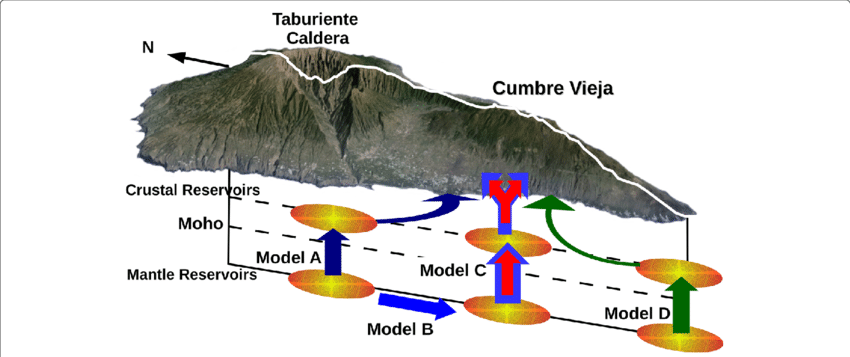

In this paper, we look at recent seismicity data to see if we can see evidence of such a system action, see <a href="#fig-reservoirs" class="quarto-xref">Figure 2</a>.
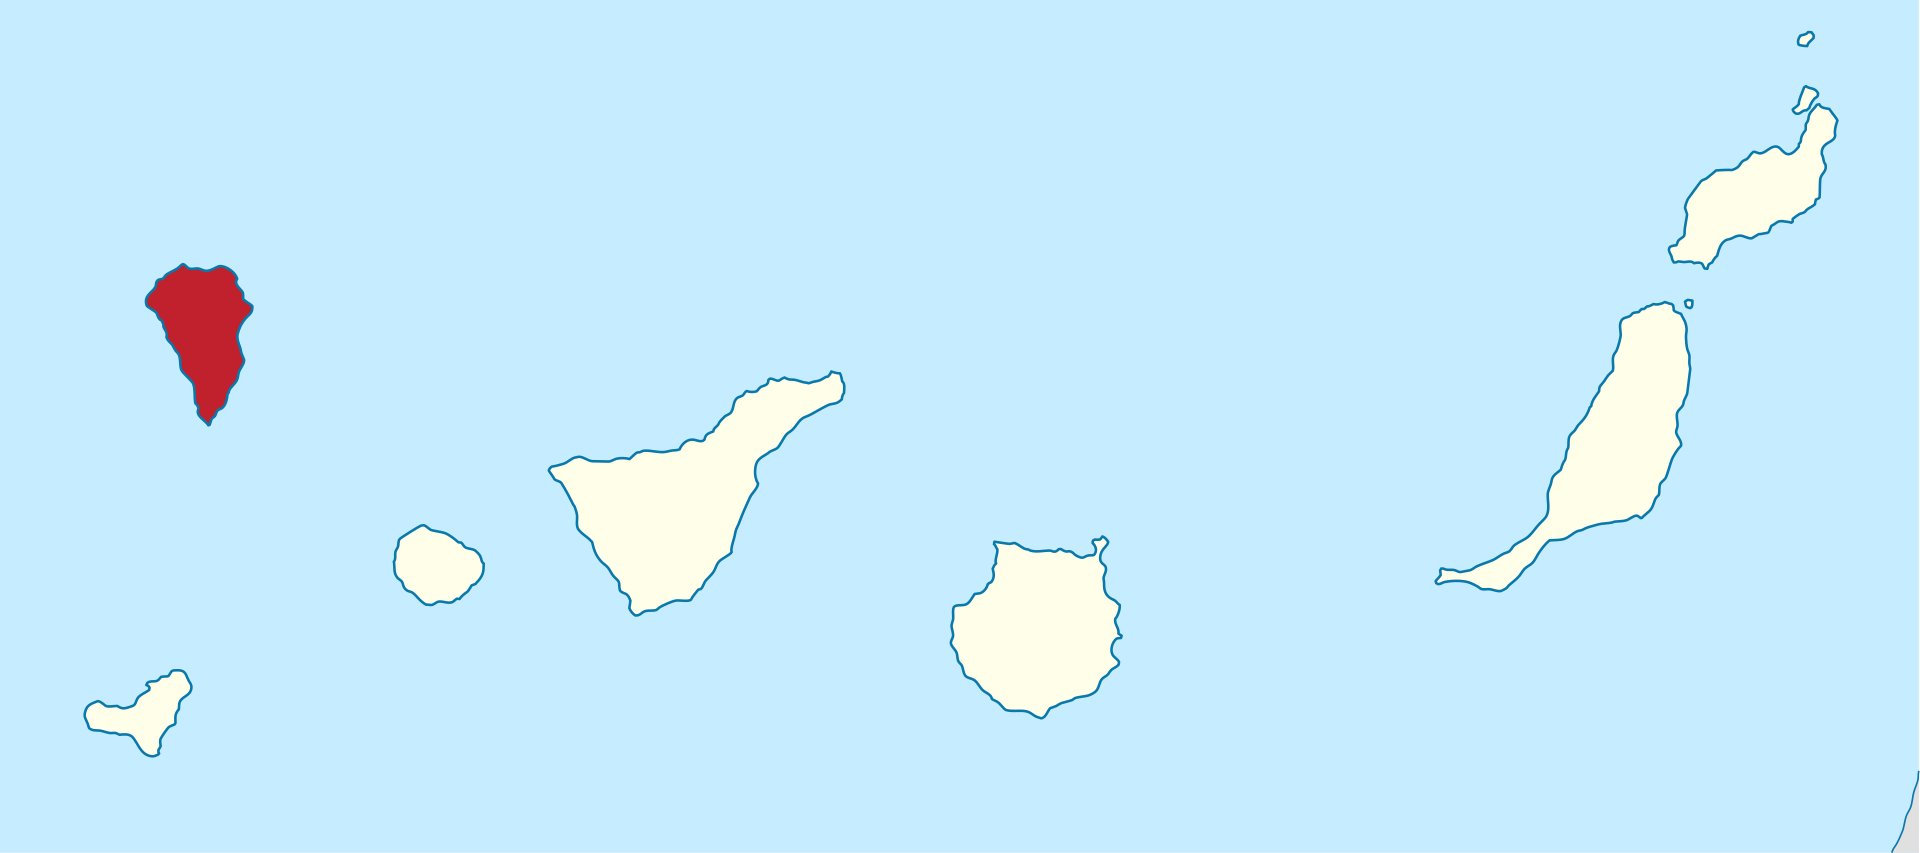

# Dataset

> All data used in the notebook should be present in the `data/` folder so notebooks may be executed in place with no additional input.

The earthquake dataset used in our analysis was generated from the [IGN web portal](https://www.ign.es/web/resources/volcanologia/tproximos/canarias.html) this is public data released under a permissive license. Data recorded using the network of Seismic Monitoring Stations on the island. A web scraping script was developed to pull data into a machine-readable form for analysis. That code tool [is available on GitHub](https://github.com/stevejpurves/ign-earthquake-data) along with a copy of recently updated data.

## Main Timeline Figure

> Code cells may be seamlessly interleaved with markdown cells. There are a variety of execution options to control the behavior of code cells - learn more in [Quarto’s documentation on execution options](https://quarto.org/docs/computations/execution-options.html).

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

In [2]:
def make_category_columns(df):
    df['Depth'] = 'Shallow (<18km)'
    df.loc[(df['Depth(km)'] >= 18) & (df['Depth(km)'] <= 28), 'Depth'] = 'Interchange (18km>x>28km)'
    df.loc[df['Depth(km)'] >= 28, 'Depth'] = 'Deep (>28km)'
    
    df['Mag'] = 0
    df.loc[(df['Magnitude'] >= 1) & (df['Magnitude'] <= 2), 'Mag'] = 1
    df.loc[(df['Magnitude'] >= 2) & (df['Magnitude'] <= 3), 'Mag'] = 2
    df.loc[(df['Magnitude'] >= 3) & (df['Magnitude'] <= 4), 'Mag'] = 3
    df.loc[(df['Magnitude'] >= 4) & (df['Magnitude'] <= 5), 'Mag'] = 4    
    
    return df

## Visualising Long term earthquake data

Data taken directly from the IGN Catalog

> Supported cell outputs below include `pandas` dataframe, raw text output, `matplotlib` plot, and `seaborn` plot.

In [3]:
df_ign = pd.read_csv('./data/lapalma_ign.csv')
df_ign = make_category_columns(df_ign)
df_ign.head()

In [4]:
df_ign['DateTime'] = pd.to_datetime(df_ign['Date'] + ' ' + df_ign['Time'])
df_ign['DateTime'];

In [5]:
df_ign_early = df_ign[df_ign['DateTime'] < '2021-09-11']
df_ign_pre = df_ign[(df_ign['DateTime'] >= '2021-09-11')&(df_ign['DateTime'] < '2021-09-19 14:13:00')]
df_ign_phase1 = df_ign[(df_ign['DateTime'] >= '2021-09-19 14:13:00')&(df_ign['DateTime'] < '2021-10-01')]
df_ign_phase2 = df_ign[(df_ign['DateTime'] >= '2021-10-01')&(df_ign['DateTime'] < '2021-12-01')]
df_ign_phase3 = df_ign[(df_ign['DateTime'] >= '2021-12-01')&(df_ign['DateTime'] <= '2021-12-31')]

df_erupt = df_ign[(df_ign['Date'] < '2022-01-01') & (df_ign['Date'] > '2021-09-11')]

df_erupt_1 = df_erupt[df_erupt['Magnitude'] < 1.0]
df_erupt_2 = df_erupt[(df_erupt['Magnitude'] >= 1.0)&(df_erupt['Magnitude'] < 2.0)]
df_erupt_3 = df_erupt[(df_erupt['Magnitude'] >= 2.0)&(df_erupt['Magnitude'] < 3.0)]
df_erupt_4 = df_erupt[(df_erupt['Magnitude'] >= 3.0)&(df_erupt['Magnitude'] < 4.0)]
df_erupt_5 = df_erupt[df_erupt['Magnitude'] > 4.0]


In [6]:
tab20_colors = (
    (0.12156862745098039, 0.4666666666666667,  0.7058823529411765  ),  # 1f77b4
    (0.6823529411764706,  0.7803921568627451,  0.9098039215686274  ),  # aec7e8
    (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
    (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
    (0.17254901960784313, 0.6274509803921569,  0.17254901960784313 ),  # 2ca02c
    (0.596078431372549,   0.8745098039215686,  0.5411764705882353  ),  # 98df8a
    (0.8392156862745098,  0.15294117647058825, 0.1568627450980392  ),  # d62728
    (1.0,                 0.596078431372549,   0.5882352941176471  ),  # ff9896
    (0.5803921568627451,  0.403921568627451,   0.7411764705882353  ),  # 9467bd
    (0.7725490196078432,  0.6901960784313725,  0.8352941176470589  ),  # c5b0d5
    (0.5490196078431373,  0.33725490196078434, 0.29411764705882354 ),  # 8c564b
    (0.7686274509803922,  0.611764705882353,   0.5803921568627451  ),  # c49c94
    (0.8901960784313725,  0.4666666666666667,  0.7607843137254902  ),  # e377c2
    (0.9686274509803922,  0.7137254901960784,  0.8235294117647058  ),  # f7b6d2
    (0.4980392156862745,  0.4980392156862745,  0.4980392156862745  ),  # 7f7f7f
    (0.7803921568627451,  0.7803921568627451,  0.7803921568627451  ),  # c7c7c7
    (0.7372549019607844,  0.7411764705882353,  0.13333333333333333 ),  # bcbd22
    (0.8588235294117647,  0.8588235294117647,  0.5529411764705883  ),  # dbdb8d
    (0.09019607843137255, 0.7450980392156863,  0.8117647058823529  ),  # 17becf
    (0.6196078431372549,  0.8549019607843137,  0.8980392156862745),    # 9edae5
)

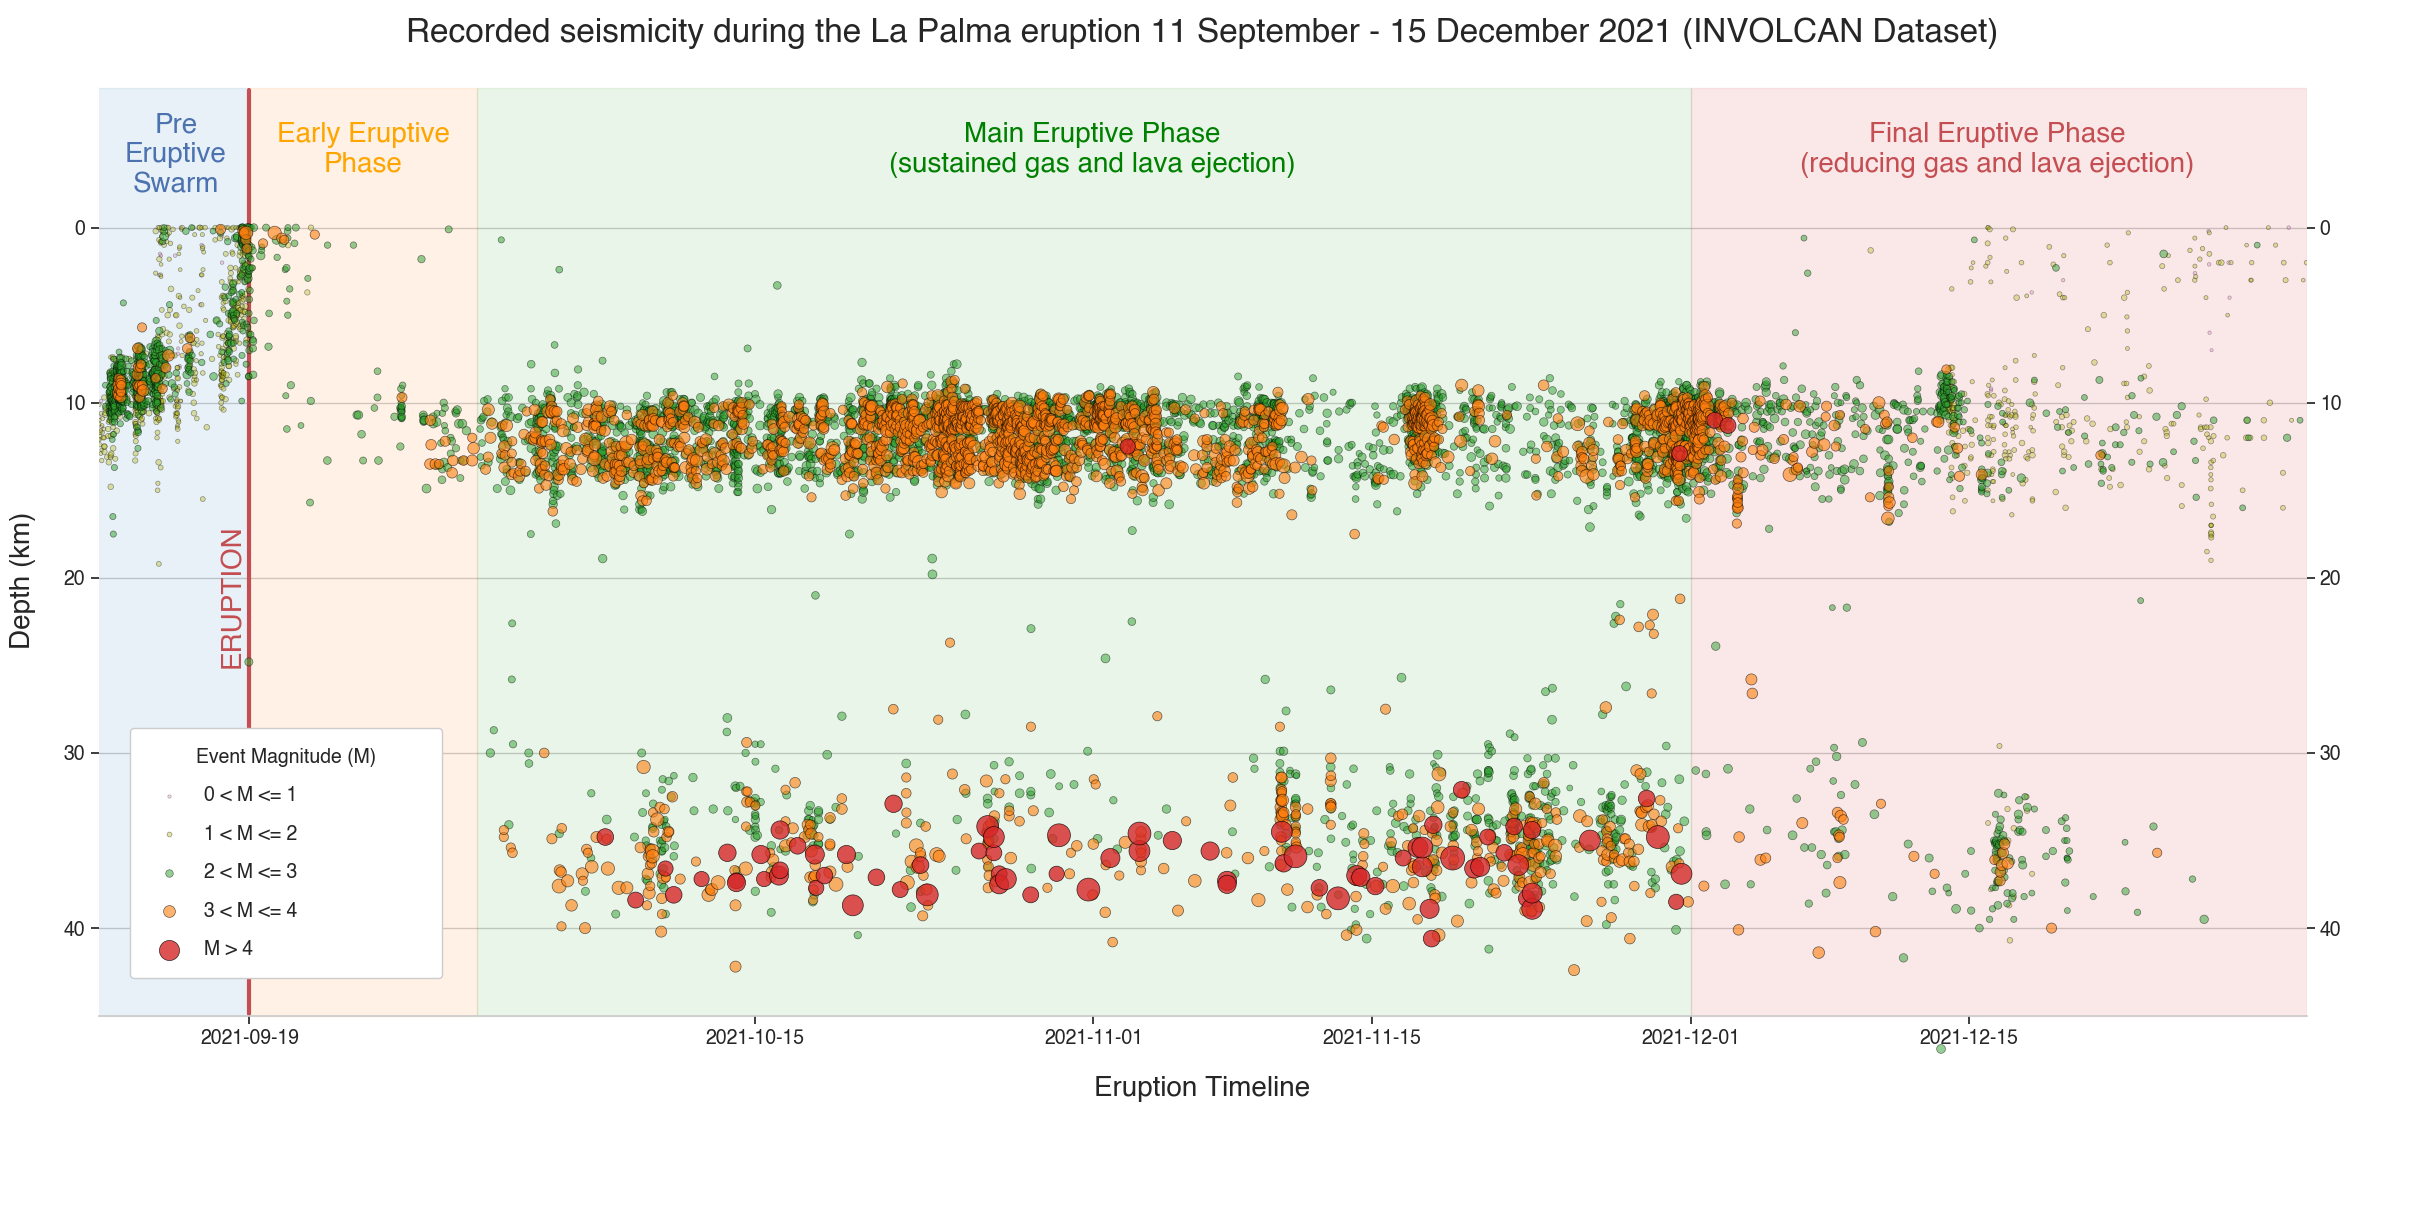

In [7]:
from matplotlib.patches import Rectangle

import datetime as dt
from matplotlib.dates import date2num, num2date

matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.labelright'] = True

%matplotlib inline
fig = matplotlib.pyplot.figure(figsize=(24,12))
fig.tight_layout()
# Creating axis
# add_axes([xmin,ymin,dx,dy])
ax_min = fig.add_axes([0.01, 0.01, 0.01, 0.01])
ax_min.axis('off')
ax_max = fig.add_axes([0.99, 0.99, 0.01, 0.01])
ax_max.axis('off')

ax_timeline = fig.add_axes([0.04, 0.1, 0.92, 0.85])
ax_timeline.spines["top"].set_visible(False)
ax_timeline.spines["right"].set_visible(False)
ax_timeline.spines["left"].set_visible(False)
ax_timeline.grid(axis='x')


ax_timeline.axvline(x=dt.datetime(2021, 9, 19, 14, 13), ymin=0.075, ymax=0.98, color='r', linewidth=3)


def make_scatter(df, c, alpha=0.8):
    M = 3*np.exp2(1.3*df['Magnitude'])
    return ax_timeline.scatter(df['DateTime'], df['Depth(km)'], s=M, c=c, alpha=alpha, edgecolor='black', linewidth=0.5, zorder=2);

# make_scatter(df_erupt, c=tab20c_colors[-1])
points_1 = make_scatter(df_erupt_1, c=[tab20_colors[12]], alpha=0.3)
points_2 = make_scatter(df_erupt_2, c=[tab20_colors[16]], alpha=0.4)
points_3 = make_scatter(df_erupt_3, c=[tab20_colors[4]], alpha=0.5)
points_4 = make_scatter(df_erupt_4, c=[tab20_colors[2]], alpha=0.6)
points_5 = make_scatter(df_erupt_5, c=[tab20_colors[6]], alpha=0.8)

ax_timeline.tick_params(axis='x', labelrotation=0, bottom=True)
ax_timeline.set_ylabel('')
ax_timeline.yaxis.set_ticks_position('both')
ax_timeline.yaxis.set_ticks_position('both')

xticks = ax_timeline.get_xticks()
new_xticks = [date2num(pd.to_datetime('2021-09-11')),
    date2num(pd.to_datetime('2021-09-19 14:13:00'))]
new_xticks = np.append(new_xticks, xticks[2:-1])
ax_timeline.set_xticks(new_xticks)

ax_timeline.invert_yaxis()
ax_timeline.spines['bottom'].set_position(('data', 45))
ax_timeline.margins(tight=True, x=0)
ax_timeline.legend(
    [points_1, points_2, points_3, points_4, points_5],
    ['0 < M <= 1','1 < M <= 2','2 < M <= 3','3 < M <= 4','M > 4'],
    loc='lower left', bbox_to_anchor=(0.01, 0.1, 0.15, 0.1), fancybox=True,
    borderpad=1.0, labelspacing=1, mode="expand", title="Event Magnitude (M)",
    fontsize=14, title_fontsize=14, framealpha=1)

ax_timeline.set_ylim(ax_timeline.get_ylim()[0], -9)

plt.annotate('ERUPTION', (0.055, 0.42), rotation=90, xycoords='axes fraction', fontweight='bold', fontsize=20, color='r')
plt.annotate('Pre\nEruptive\nSwarm', (0.035, 0.88), rotation=0, xycoords='axes fraction', fontweight='bold', fontsize=20, color='b', horizontalalignment='center')
plt.annotate('Early Eruptive\nPhase', (0.12, 0.9), rotation=0, xycoords='axes fraction', fontweight='bold', fontsize=20, color='orange', horizontalalignment='center')
plt.annotate('Main Eruptive Phase\n(sustained gas and lava ejection)', (0.45, 0.9), rotation=0, xycoords='axes fraction', fontweight='bold', fontsize=20, color='green', horizontalalignment='center')
plt.annotate('Final Eruptive Phase\n(reducing gas and lava ejection)', (0.86, 0.9), rotation=0, xycoords='axes fraction', fontweight='bold', fontsize=20, color='r', horizontalalignment='center')

ax_timeline.add_patch(Rectangle((date2num(pd.to_datetime('2021-09-11')), -8), date2num(pd.to_datetime('2021-09-19 14:13:00'))-date2num(pd.to_datetime('2021-09-11')), 53, color=tab20_colors[0], zorder=1, alpha=0.1))
ax_timeline.add_patch(Rectangle((date2num(pd.to_datetime('2021-09-19 14:13:00')), -8), date2num(pd.to_datetime('2021-10-01'))-date2num(pd.to_datetime('2021-09-19 14:13:00')), 53, color=tab20_colors[2], zorder=1, alpha=0.1))
ax_timeline.add_patch(Rectangle((date2num(pd.to_datetime('2021-10-01')), -8), date2num(pd.to_datetime('2021-12-01'))-date2num(pd.to_datetime('2021-10-01')), 53, color=tab20_colors[4], zorder=1, alpha=0.1))
ax_timeline.add_patch(Rectangle((date2num(pd.to_datetime('2021-12-01')), -8), date2num(pd.to_datetime('2021-12-31'))-date2num(pd.to_datetime('2021-12-01'))+1, 53, color=tab20_colors[6], zorder=1, alpha=0.1));

ax_timeline.set_title("Recorded seismicity during the La Palma eruption 11 September - 15 December 2021 (INVOLCAN Dataset)", dict(fontsize=24), pad=20)
ax_timeline.set_ylabel("Depth (km)", dict(fontsize=20), labelpad=20)
ax_timeline.set_xlabel("Eruption Timeline", dict(fontsize=20), labelpad=20);


## Cumulative Distribution Plots

In [8]:
def cumulative_events_mag_depth(df, hue='Depth', kind='scatter', ax=None, dpi=100, palette=None, kde=True):
    matplotlib.rcParams['ytick.labelright'] = False
    g = sns.jointplot(x="Magnitude", y="Depth(km)", data=df,
                      kind=kind, hue=hue, height=10, space=0.1, marginal_ticks=False, ratio=8, alpha=0.6,
                      hue_order=['Shallow (<18km)', 'Interchange (18km>x>28km)', 'Deep (>28km)'],
                      ax=ax, palette=palette, ylim=(-2,50), xlim=(0.3,5.6), edgecolor=".2", marginal_kws=dict(bins=20, hist_kws={'edgecolor': 'black'}))
    if kde:
        g.plot_joint(sns.kdeplot, color="b", zorder=1, levels=15, ax=ax)
    g.fig.axes[0].invert_yaxis();
    g.fig.set_dpi(dpi)

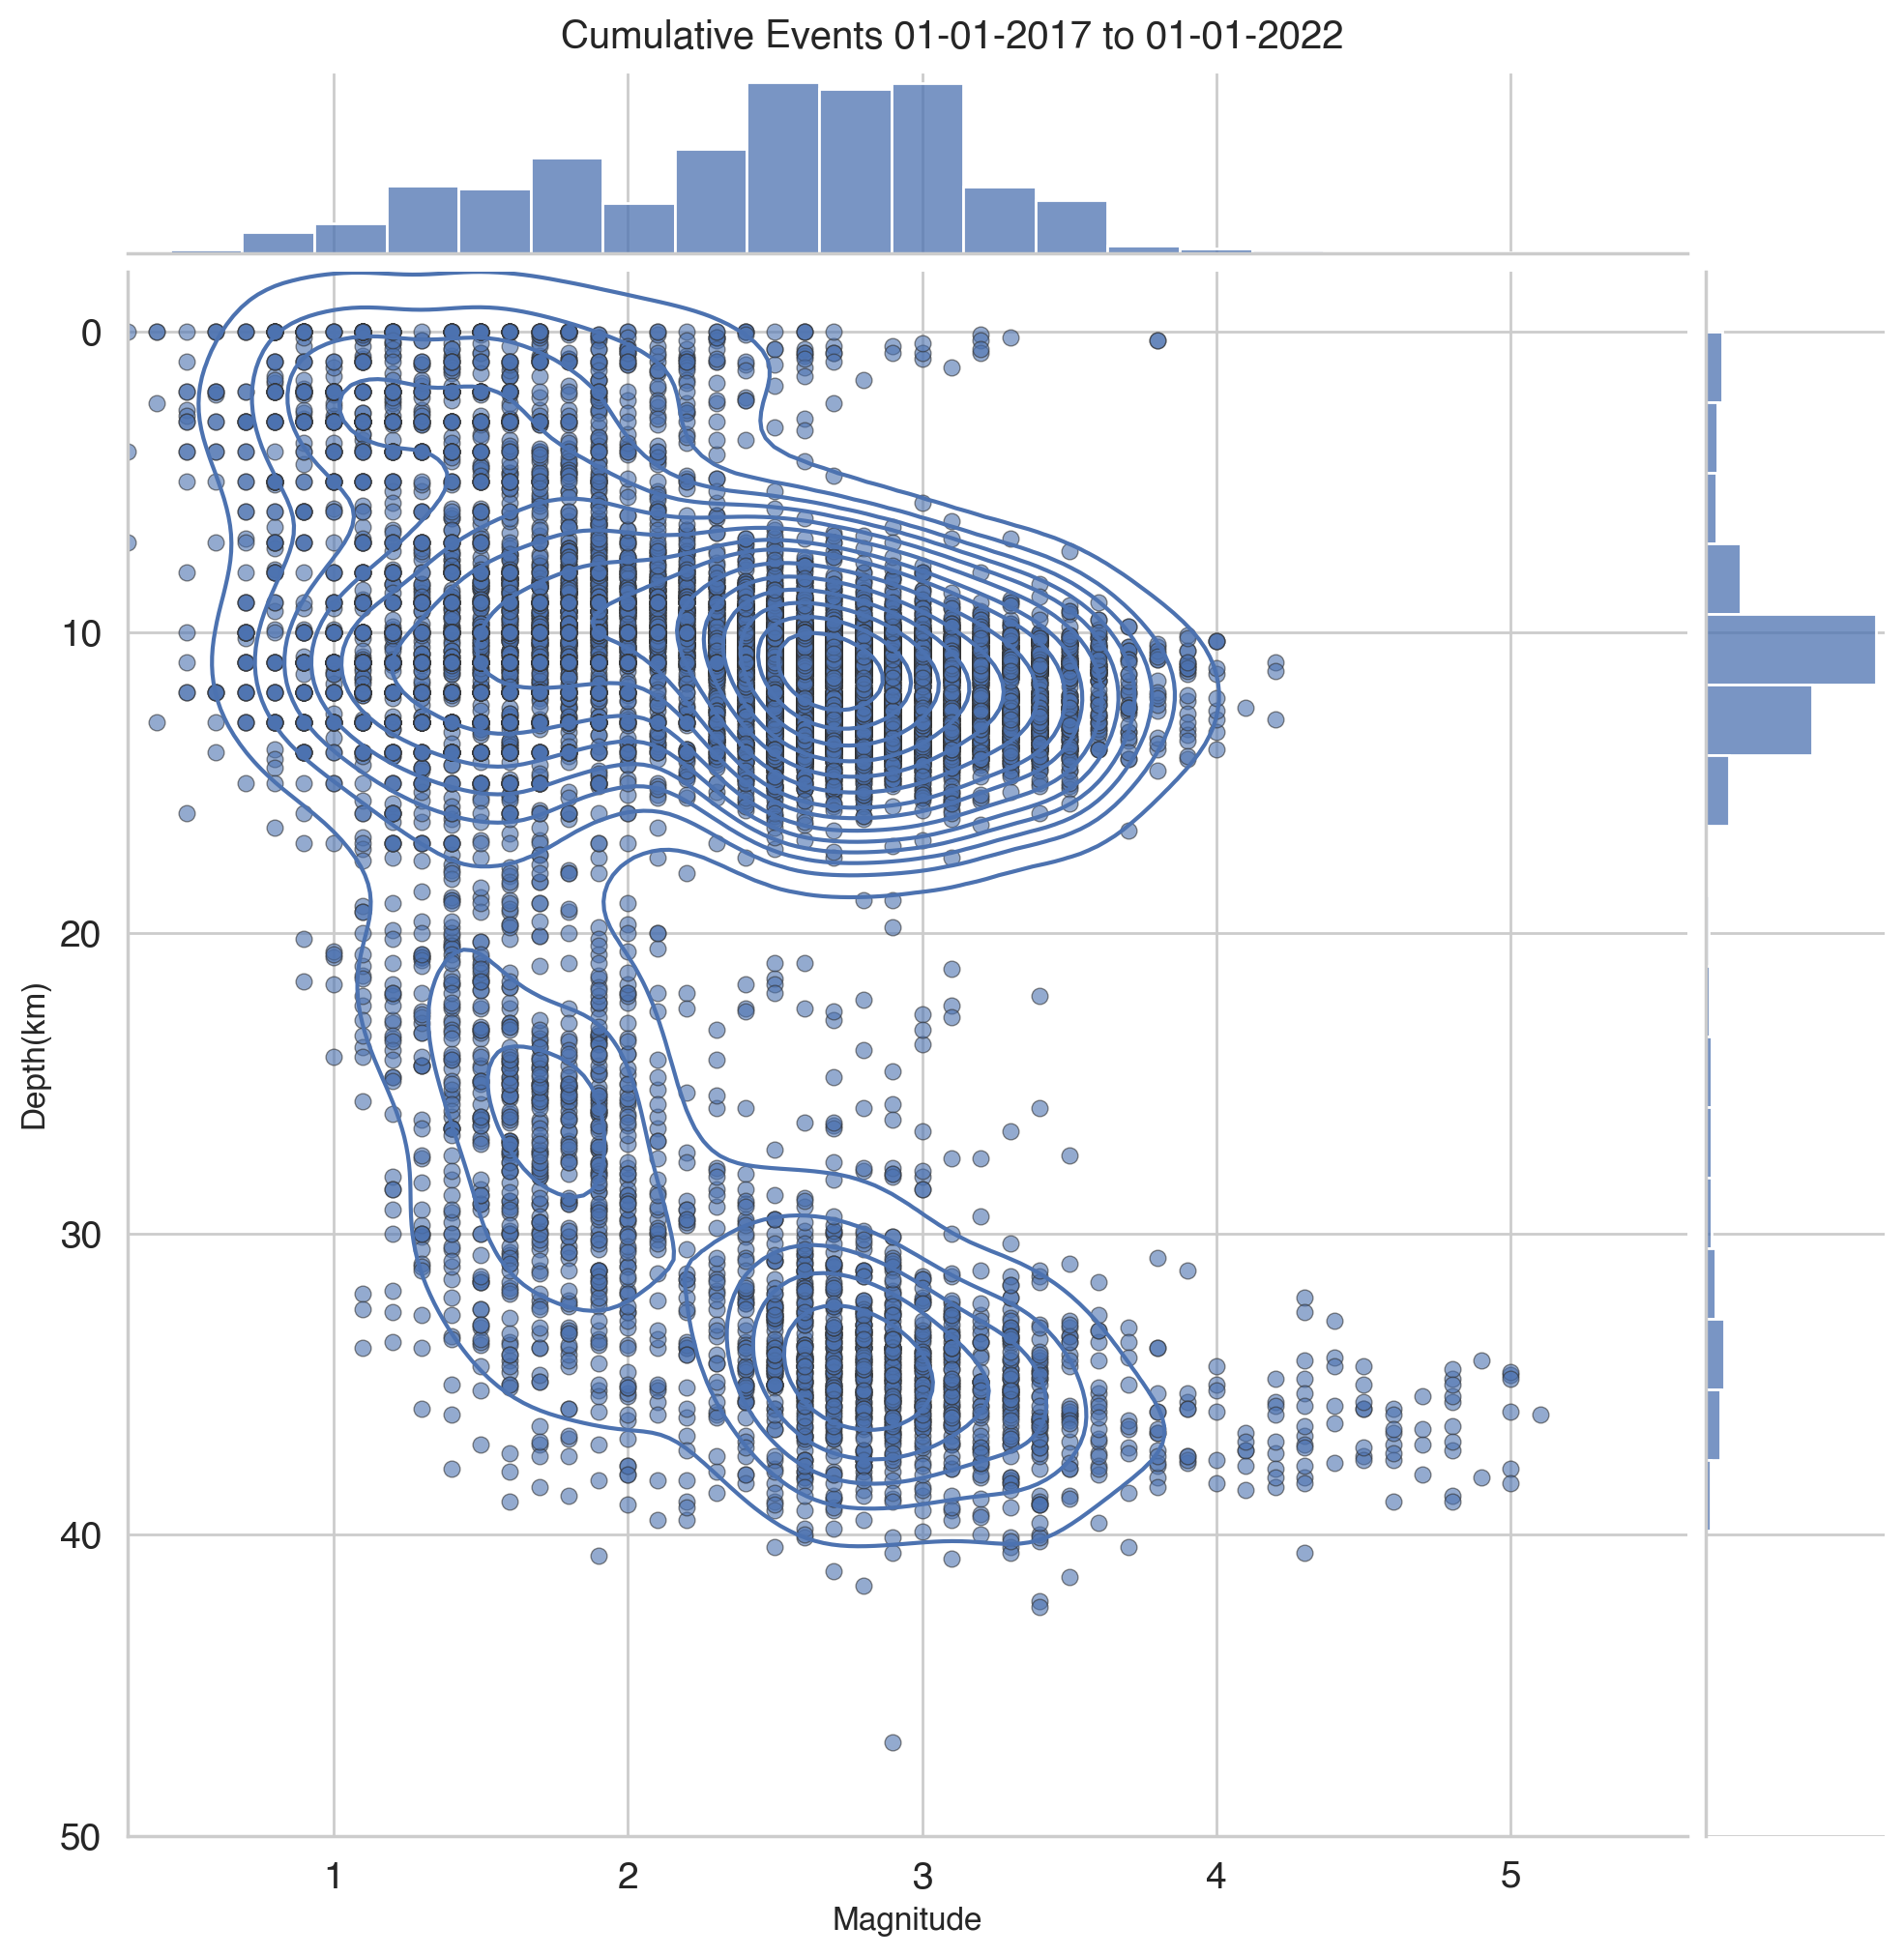

In [9]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cumulative_events_mag_depth(df_ign, hue=None, dpi=200)
    plt.suptitle('Cumulative Events 01-01-2017 to 01-01-2022', y=1.01);

# Results

The dataset was loaded into this Jupyter notebook and filtered down to La Palma events only. This results in 5465 data points which we then visualized to understand their distributions spatially, by depth, by magnitude and in time.

From our analysis above, we can see 3 different systems in play.

Firstly, the shallow earthquake swarm leading up to the eruption on 19th September, related to significant surface deformation and shallow magma intrusion.

After the eruption, continuous shallow seismicity started at 10-15km corresponding to magma movement in the crustal reservoir.

Subsequently, high magnitude events begin occurring at 30-40km depths corresponding to changes in the mantle reservoir. These are also continuous but occur with a lower frequency than in the crustal reservoir.

# Conclusions

From the analysis of the earthquake data collected and published by IGN for the period of 11 September through to 9 November 2021. Visualization of the earthquake events at different depths appears to confirm the presence of both mantle and crustal reservoirs as proposed by Marrero et al. ([2019](#ref-marrero2019)).

> Data availability statement should be specified in a separate cell with metadata `"part": "availability"`, similar to the abstract.
>
> AGU requires an Availability Statement for the underlying data needed to understand, evaluate, and build upon the reported research at the time of peer review and publication.

A web scraping script was developed to pull data into a machine-readable form for analysis. That code tool [is available on GitHub](https://github.com/stevejpurves/ign-earthquake-data) along with a copy of recently updated data.

## References

Marrero, José, Alicia García, Manuel Berrocoso, Ángeles Llinares, Antonio Rodríguez-Losada, and R. Ortiz. 2019. “Strategies for the Development of Volcanic Hazard Maps in Monogenetic Volcanic Fields: The Example of La Palma (Canary Islands).” *Journal of Applied Volcanology* 8 (July). <https://doi.org/10.1186/s13617-019-0085-5>.